In [ ]:
# LINK TO MODEL WEIGHTS AND DEMO SCRIPT FILES
# https://drive.google.com/drive/folders/1ivLoeDOIaYvjsUSYt9MUGbm6oew2srJj?usp=sharing

In [ ]:
# Link to the dataset and reference-notebook
# https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
# https://www.kaggle.com/code/arshkandroo/image-segmentation-using-6-models-pytorch

In [129]:
# Common
import os
import keras #maybe not needed
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf #nn
import sys 

# pytorch
import torch
import torchvision
from glob import glob
import torch.nn as nn
import tqdm
from tqdm import notebook
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torchviz import make_dot

# Importing the library into the notebook
# if the next module is not installed then use - !pip install segmentation-models-pytorch
import segmentation_models_pytorch as seg_models


# Data Viz
import matplotlib.pyplot as plt

In [130]:
image_dir = './cityscapes_data'
train_path = './cityscapes_data/train'
valid_path = './cityscapes_data/val'
working_dir = './working'
train_files = os.listdir(train_path)
val_files = os.listdir(valid_path)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

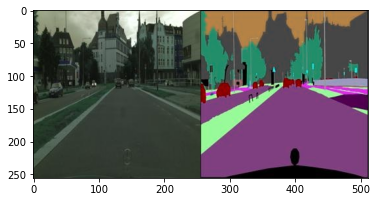

In [131]:
# Check one image
img = cv2.imread(train_path + '/2.jpg')
if img is None:
    sys.exit("Could not read the image.")
plt.imshow(img)
plt.show()

In [132]:
img.shape
# plt.imshow(img)
# plt.show()

(256, 512, 3)

In [133]:
class data_load(object):
    def __init__(self, images_dir, batch_size, shuffle = True, rescale = 1.00, target_size = (128, 128)):
        super(data_load, self).__init__()
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.rescale = rescale
        self.shuffle = shuffle
        self.target_size = target_size
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.step_number = 0
        self.total_steps = int(len(self.filenames) // self.batch_size)
        
    def generate_batch(self):
        start = self.step_number * self.batch_size
        stop = (self.step_number + 1) * self.batch_size
        filenames_batch = self.filenames[start:stop]
        
        images_batch = [cv2.imread(filename) for filename in filenames_batch]
        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])
        
        # To separate images and their labels
        images_batch = np.array([(image[:, :256,], image[:, 256:]) for image in images_batch])
        
        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image, mask) in images_batch], dtype = np.float32)
        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])
        images_batch /= self.rescale
        images_batch = np.moveaxis(images_batch, 1, 0)
        
        return torch.Tensor(images_batch)
    
    def __next__(self):
        if self.step_number > self.total_steps:
            self.step_number = 0
        images, masks = self.generate_batch()
        self.step_number += 1
        return images, masks
    
    def __len__(self):
        return self.total_steps

In [134]:
def dice(pred, label):
    pred = (pred > 0).float()
    return 2. * (pred*label).sum() / (pred+label).sum()

In [135]:
def training(model, epochs, batch_size):
 
    train_generator = data_load(images_dir = train_path, batch_size = batch_size, rescale = 255.0)
    test_generator = data_load(images_dir = valid_path, batch_size = batch_size, rescale = 255.0)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    main_pbar = tqdm.notebook.tqdm(range(epochs))
    main_pbar.set_description('common progress ')
    
    for epoch in main_pbar:
        running_params = dict(train_loss = [], 
                               train_dice = [], 
                               test_loss = [], 
                               test_dice = [])
        train_pbar = tqdm.notebook.tqdm(range(len(train_generator)))
        
        for step in train_pbar:
            train_imgs, train_masks = next(train_generator)
            train_imgs, train_masks = train_imgs.to(device), train_masks.to(device)
            
            optimizer.zero_grad()
            
            train_predictions = model(train_imgs)

            train_loss = criterion(train_predictions, train_masks)
            train_loss.backward()
            
            train_dice = dice(pred = train_predictions, label = train_masks)
            
            optimizer.step()
        
            with torch.no_grad():
                test_images, test_masks = next(test_generator)
                test_images, test_masks = test_images.to(device), test_masks.to(device)
            
                test_predictions = model(test_images)
    
                test_loss = criterion(test_predictions, test_masks)
        
                test_dice = dice(pred = test_predictions, label = test_masks)
                
            
            current_metrics = dict(train_loss = [train_loss.item(), ], 
                                   train_dice = [train_dice.item(), ], 
                                   test_loss = [test_loss.item(),], 
                                   test_dice = [test_dice.item(),])
            
            running_params.update(current_metrics)
            
            mean_metrics = dict(zip(running_params.keys(), [(sum(tensor) / (step + 1)) for tensor in running_params.values()]))
    
            train_pbar.set_postfix(mean_metrics)
            torch.cuda.empty_cache()
        
        temp = [train_loss.item(), train_dice.item(), test_loss.item(), test_dice.item()]
        logs.append(temp)
        history.update(running_params)
        best_loss = max(history['test_loss'])
        best_loss_index =  history['test_loss'].index(best_loss)
        current_loss_index = history['test_loss'].index(test_loss.item())
        if abs(current_loss_index - best_loss_index) >= 5:
            for param_group in optim.param_groups:
                if param_group['lr'] * 0.1 > 1e-6:
                    print('reduce learning rate to', {param_group['lr'] * 0.1})
                    param_group['lr'] *= 0.1

In [142]:
histories = []
name = 'UNet'
model_name = seg_models.Unet(classes=3)
model_name.to("cuda:0")
x = torch.zeros(8, 3, 128, 128, dtype=torch.float, requires_grad=False)
x = x.to("cuda:0")
outputs_x = model_name(x)
make_dot(outputs_x, params=dict(list(model_name.named_parameters())))

optimizer = torch.optim.Adam(params = model_name.parameters(), 
                         lr=1e-4, 
                         betas=(0.9, 0.999), 
                         eps=1e-08, 
                         weight_decay=0, 
                         amsgrad=False)

criterion = torch.nn.BCEWithLogitsLoss()

history = dict(train_loss = [], 
               train_dice = [], 
               test_loss = [], 
               test_dice = [])

logs = []

training(model = model_name, epochs = 10, batch_size = 16) # train it on 20 and 32 for best results #2nd try 10,16

histories.append(logs)



In [ ]:
# Saving the model weights for each model in working directory
weights_path = os.path.join(working_dir, name + '_weights.pth')
logs_path = os.path.join(working_dir, name + '_logs')
torch.save(model_name.state_dict(), weights_path)

In [8]:
def show(model_name, num_cols, data):
    generator = data_load(images_dir = data, 
                           batch_size = 8, 
                           rescale = 255.0)
    result = []
    for iteration in range(num_cols):
        images, masks = next(generator)
        images_1 = images.to("cuda:0")
        
        prediction = torch.sigmoid(model_name(images_1))
        prediction = prediction.cpu().detach().numpy()
        prediction = np.moveaxis(prediction, 1, -1)
        masks = np.moveaxis(masks.numpy(), 1, -1)
        images = np.moveaxis(images.numpy(), 1, -1)
        prediction = np.concatenate(prediction)
        images = np.concatenate(images)
        masks = np.concatenate(masks)
        outputs = np.hstack([images, masks, prediction])
        result.append(outputs)

    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)
    return result

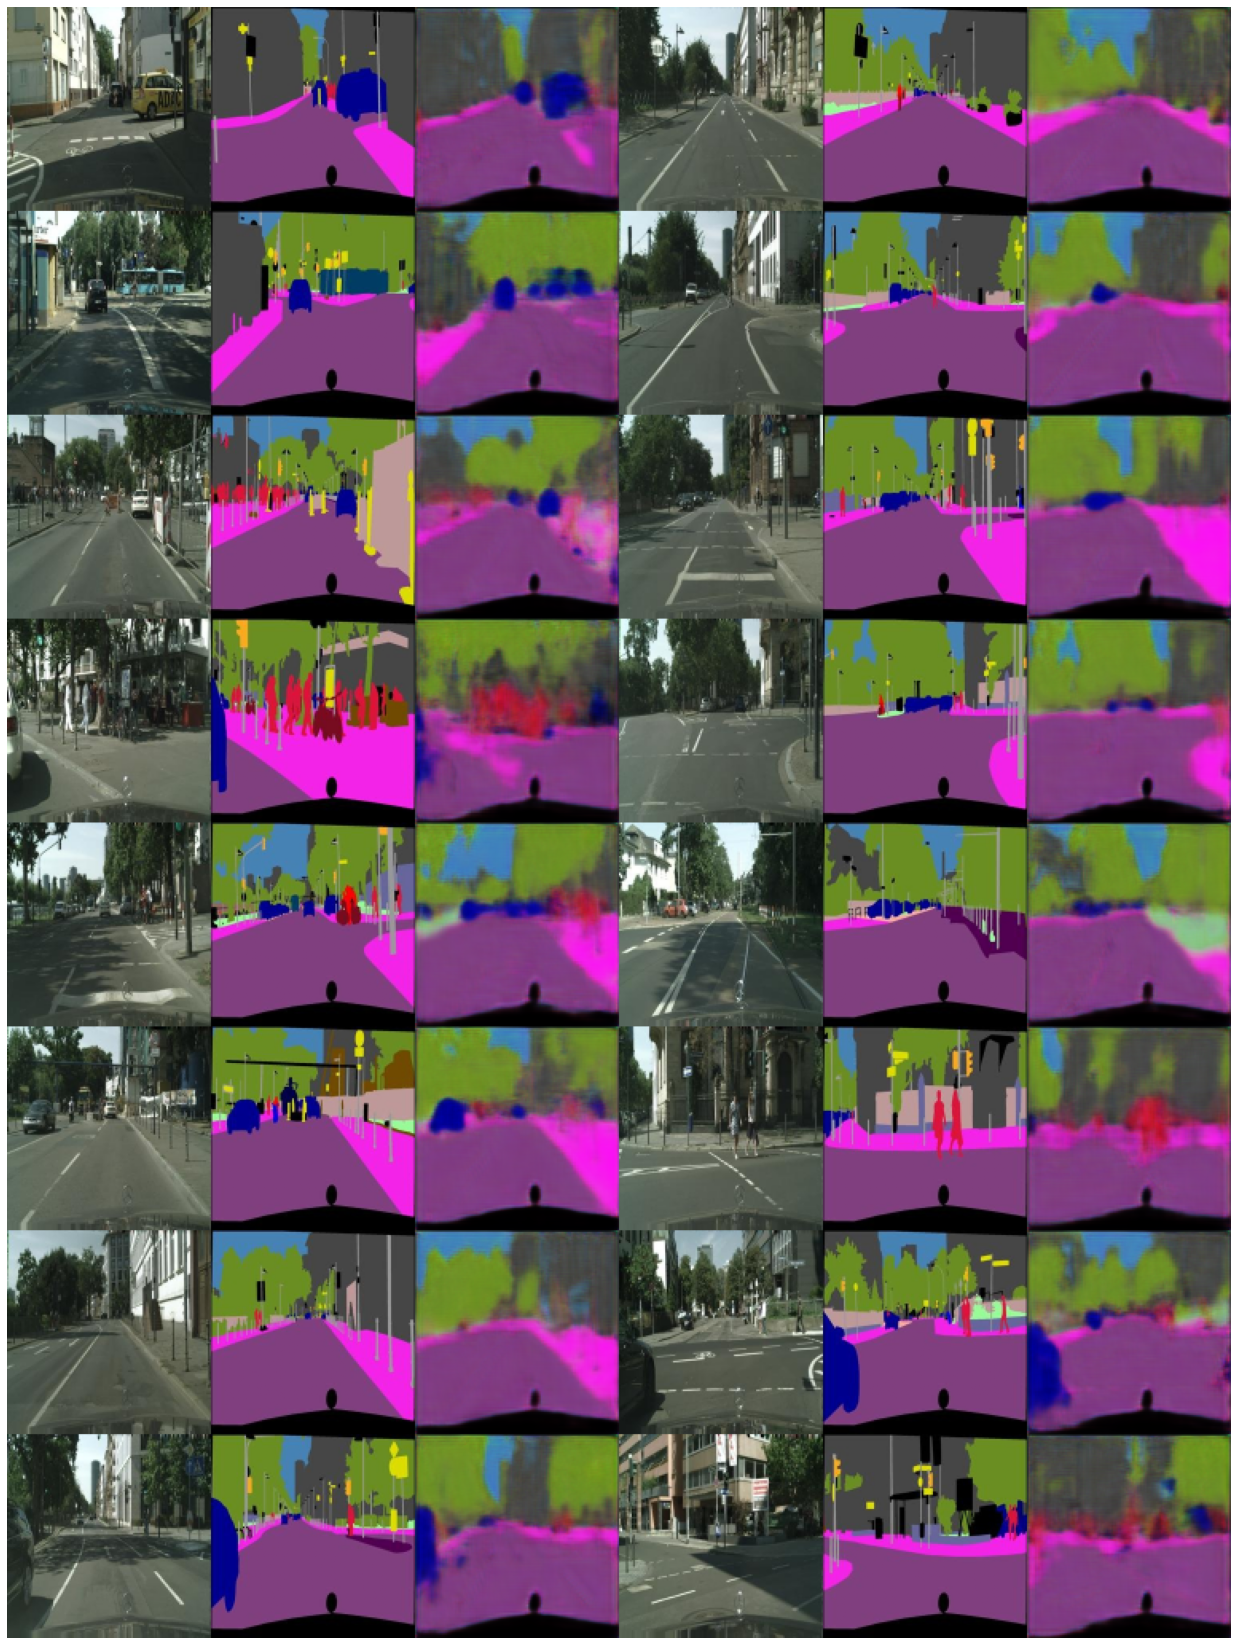

In [124]:
name = "UNet"
model_name = seg_models.Unet(classes=3)
model_name.load_state_dict(torch.load(os.path.join(working_dir, name + '_weights.pth')))
model_name.to(device)
model_name.eval()
result = show(model_name, num_cols = 2, data = valid_path)

In [13]:
# # approach 1 convert cv2 image hazy image
# # use 2nd approach
# def image_segmentation(img_path):
#     img = cv2.imread(img_path)
#     if img is None:
#         sys.exit("Could not read the image.")
#     resized = cv2.resize(img, (512,256))
#     resized = torch.from_numpy(resized)
#     resized = resized[np.newaxis, :] 
#     resized = resized.permute(0, 3, 1, 2)
#     resized = resized.float()
#     resized = resized.to(device)
#     resized_result = torch.sigmoid(model_name(resized)).cpu().detach().numpy()
#     resized_result = np.moveaxis(resized_result, 1, -1)
#     resized_result1 = np.concatenate(resized_result)
    
#     plt.figure(figsize = (10, 10))
#     plt.axis('off')
#     plt.imshow(resized_result1)

In [15]:
#approach 2 use the same format as input images
# use the following to prepare hazy data
def preprocess_image_to_folder(img_path, destination_path):
    img = cv2.imread(img_path)
    if img is None:
        sys.exit("Could not read the image.")
    resized = np.concatenate((img, img), axis=1)
    resized = cv2.resize(resized, (512,256))
    cv2.imwrite(destination_path, resized)

In [294]:
preprocess_image_to_folder("./haze_data/23_hazy.png", "./temp_data/temp_hazy.png")

In [143]:
def calculate_dice_score(result):
    height, width, channel = result.shape
    images = height//128
    ch_height = int(np.floor(height/images))
    ch_width = int(np.floor(width/3))
    dice_score = []
    
    for i in range(images):
        im_predicted = result[128*i: 128*(i+1), ch_width*2:ch_width*3, 0:channel]
        im_original = result[128*i: 128*(i+1), ch_width:ch_width*2, 0:channel]
        dice_score.append(2. * (im_predicted*im_original).sum() / (im_predicted+im_original).sum())
        
    return dice_score

In [144]:
dice_score = calculate_dice_score(result)

In [145]:
print(dice_score)

[0.4035002918028487, 0.3901761007815238, 0.40926223021097247, 0.3868879128226437, 0.3936224809626502, 0.4033895610885987, 0.3966571258664878, 0.3635251790776557]


In [146]:
#average dice score
sum(dice_score) / len(dice_score)

0.3933776103266726